## Congenital CMV - NGS Data Analysis Python Scripts
***

### Repeated Regions in CMV _wild type_ Merlin Genome

- Get CMV wild type Merlin GenBank (AY446894.2) record.\
- Get summary of the record. 

In [2]:
# Load SeqIO class from Bio package
from Bio import SeqIO
# Create genbank object using read method of SeqIO class
genbank_object=SeqIO.read("./ref/cmv_merlin.gb", "genbank")
# Print summary of genbank record.
print('ID: ', genbank_object.id)
print('Name: ', genbank_object.name)
print('Description: ', genbank_object.description)
print('Genome Size (bp):',len(genbank_object.seq))

ID:  AY446894.2
Name:  AY446894
Description:  Human herpesvirus 5 strain Merlin, complete genome
Genome Size (bp): 235646


- Get unique feature types. 

In [3]:
# Get list of all feature types
feature_types=[i.type for i in genbank_object.features]
# Build an unordered collection of unique elements.
feature_types=set(feature_types)
# Convert set to list
feature_types=list(feature_types)

print(feature_types)

['rep_origin', 'variation', 'repeat_region', 'misc_feature', 'polyA_site', 'regulatory', 'source', 'ncRNA', 'CDS', 'mRNA', 'gene', 'intron']


- Number of repeat regions in AY446894.2

In [4]:
[i.type for i in genbank_object.features].count('repeat_region')

8

- Writing repeat regions to a file 
- This file was used to show repeat regions in Summary.html file. 

In [5]:
with open('repeat_regions_file.txt', 'w') as f:
    for feature in genbank_object.features:
        if feature.type=='repeat_region':
            line=f"{feature.type}\t{feature.qualifiers['note'][0]}\t{feature.qualifiers.get('rpt_type')}\t{feature.location}"
            f.write(line+'\n')
f.close()

### Genes with High Number of Non-synonimous Missense Mutations
Gene names obtained from variant analysis.\
Theese genes have at least mean number of 10 mutations 

In [6]:

Gene_Names=['RL1','RL10','RL12','RL13','RL5A','UL1','UL11','UL116','UL119',
  'UL120','UL122','UL123','UL13','UL132','UL133','UL142','UL144','UL147',
  'UL150','UL150A','UL20','UL32','UL33','UL37','UL4','UL40','UL48','UL55',  
  'UL6','UL7','UL74','UL75','UL77','UL8','UL80','UL87','UL9','US27','US34','US7']

with open(file='high_number_sps.txt', mode='w') as document: 
    for feature in genbank_object.features:
        if (feature.qualifiers.get('gene') in [[i] for i in Gene_Names]) and feature.type=='CDS':
            print(feature.qualifiers['gene'][0],
            feature.location,
            feature.qualifiers['product'][0],
            feature.qualifiers.get('note',['None'])[0],
            sep='\t',
            file=document)
document.close()

Printing translation of a protein

In [10]:
from Bio.Seq import Seq
from Bio import SeqIO
genbank_object=SeqIO.read("./ref/cmv_merlin.gb", "genbank")
for feature in genbank_object.features:
    if feature.type=='CDS' and feature.qualifiers['gene']==['UL8']:
        IL8_prot = feature.qualifiers['translation']
#print(IL8_prot)
IL8_prot = Seq(IL8_prot[0])
#print(IL8_prot)

### Creating Circos Genotype Visualization

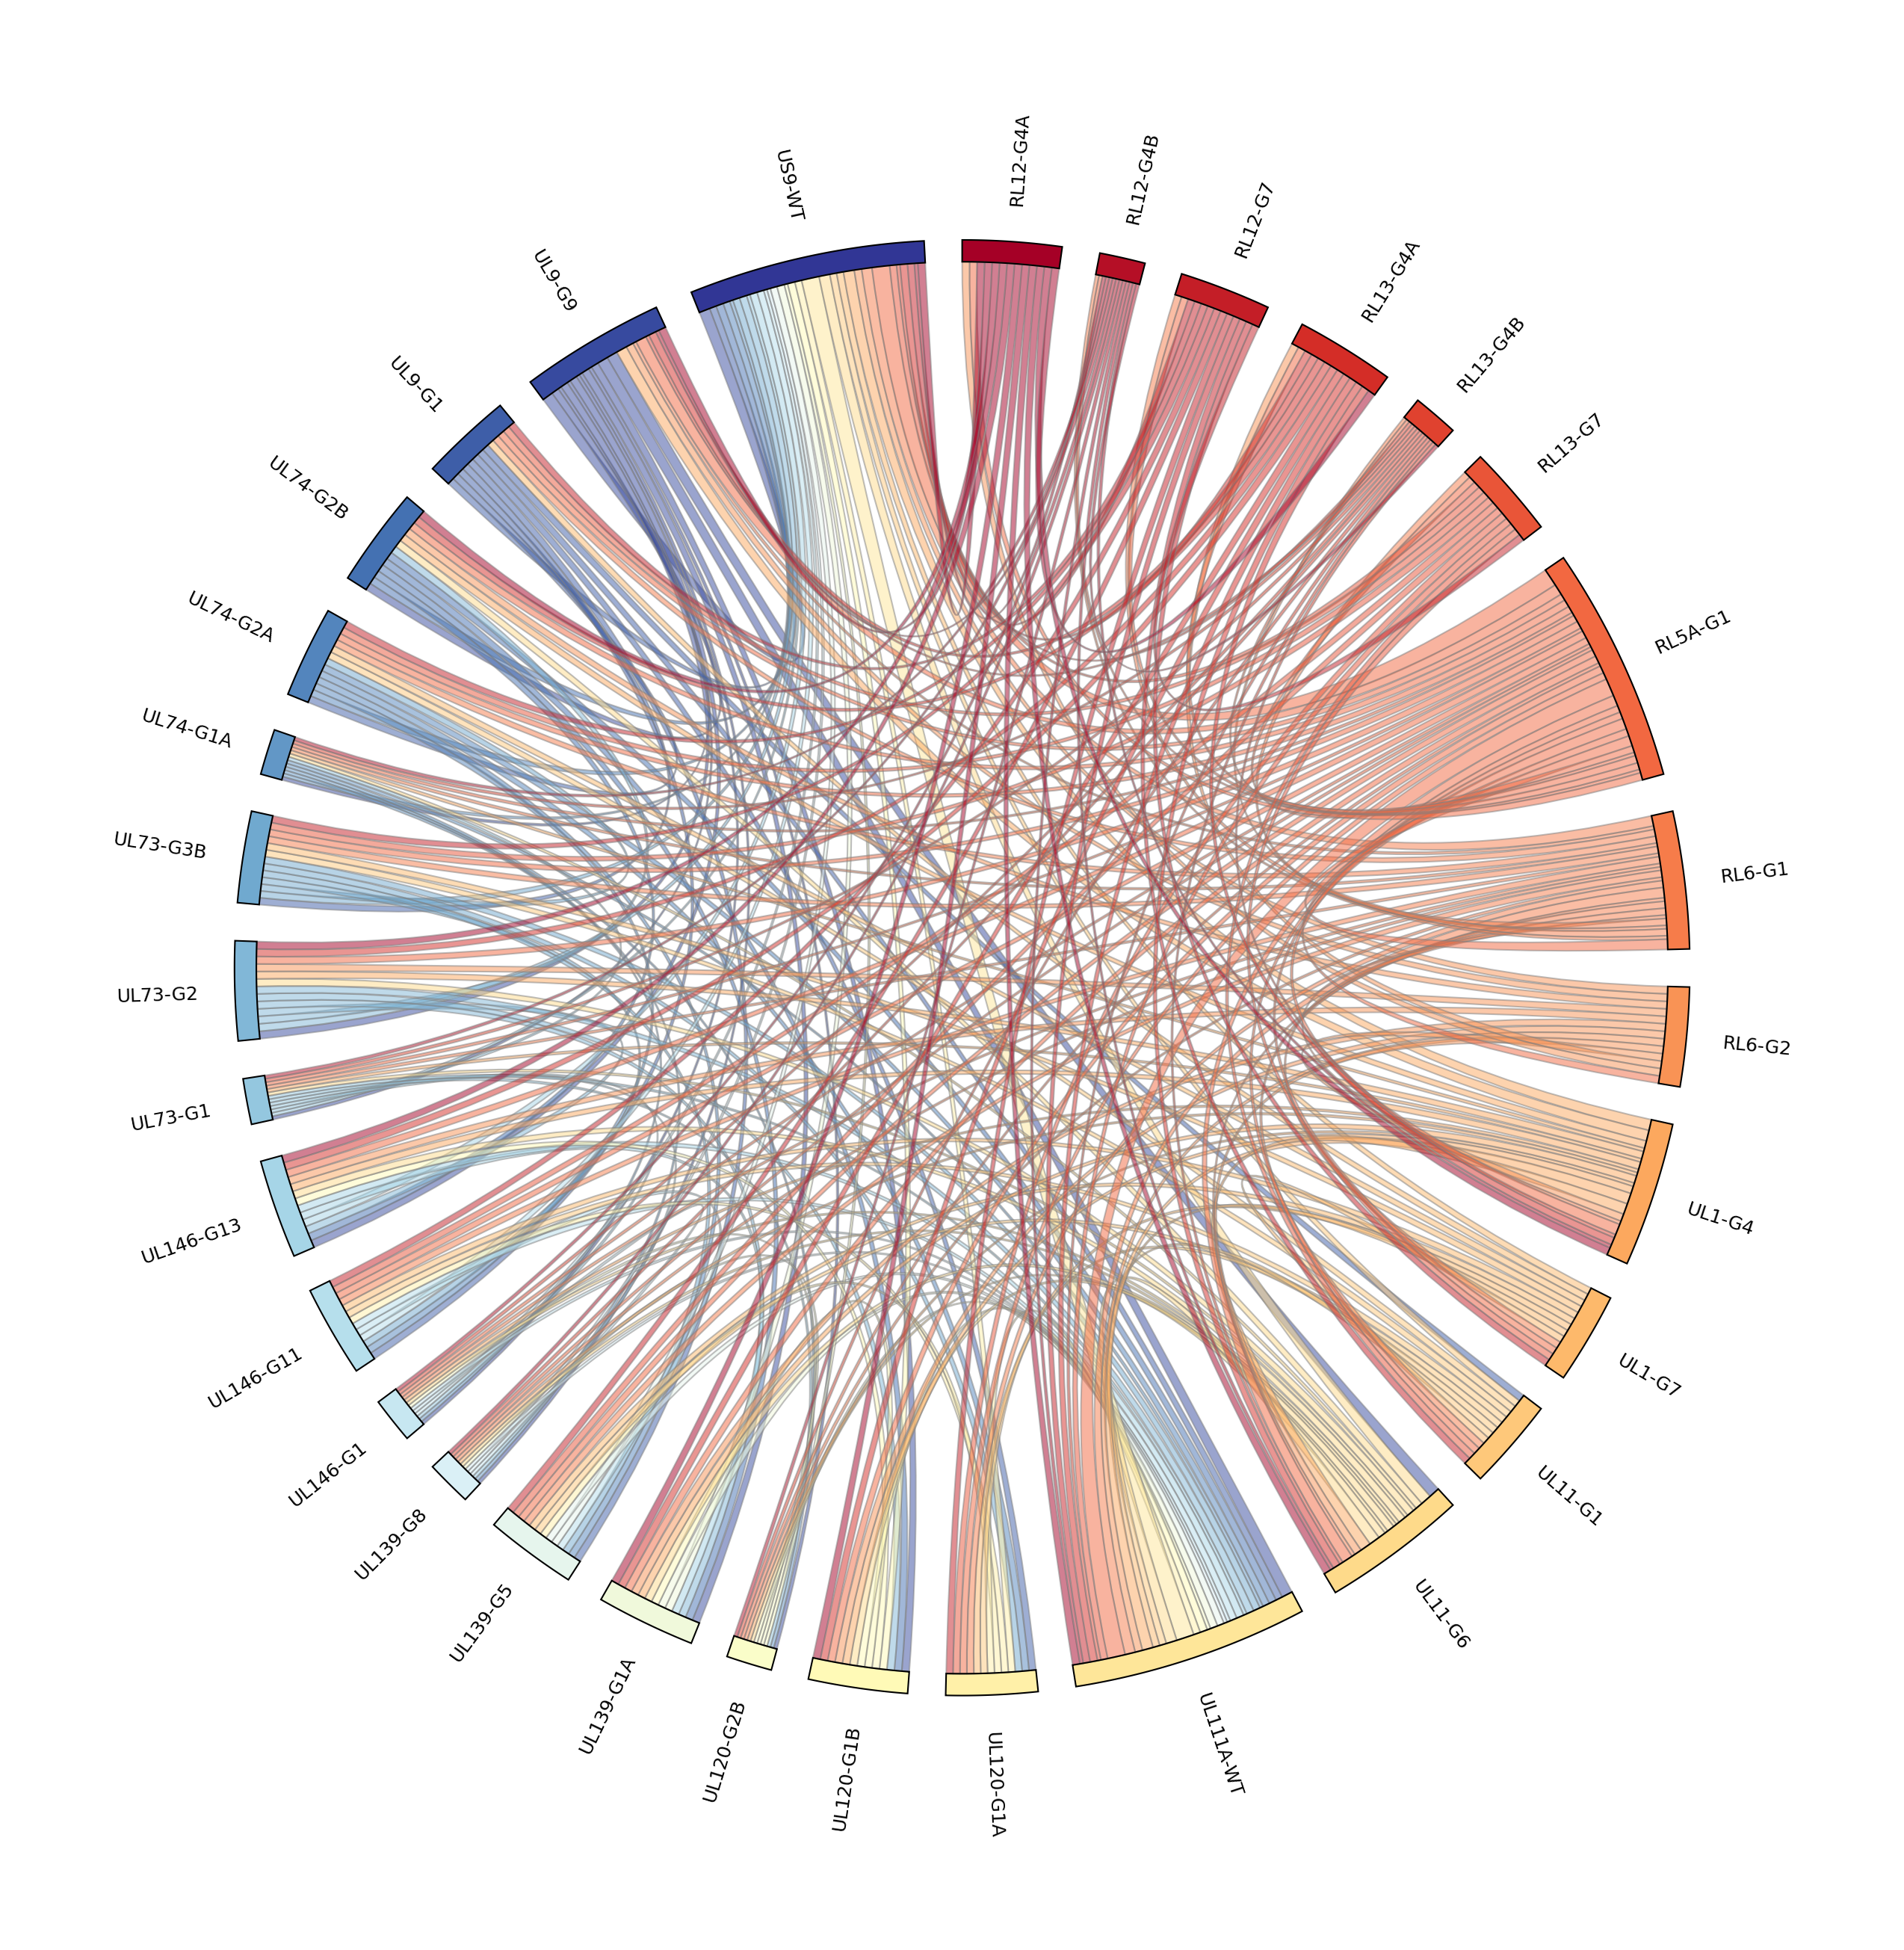

In [7]:
from pycirclize import Circos
import pandas as pd
from glob import glob
import itertools
genotype_list = list()
files = glob('./genotyping/output/*.txt') 
for file in files:
    dat=pd.read_table(file, header = None)
    dat.iloc[:,2]= dat.iloc[:,2].str.replace(pat='>',repl='')
    genotypes= dat[(dat.iloc[:,0]>10) & (dat.iloc[:,2]!='control')].iloc[:,2]
    genotype_list.extend(list(itertools.combinations(genotypes, r=2)))

agregated=pd.Series(genotype_list).value_counts().to_frame(name='counts').reset_index()
dat=pd.DataFrame(agregated['index'].to_list(),columns=['Group_1','Group_2'])
dat['counts']=agregated['counts']
mat=dat.pivot(index='Group_1', columns='Group_2', values='counts')
mat.fillna(0, inplace=True)
#dat[dat["Group_1"]=="UL111A-WT"]
#dat[dat["Group_2"]=="UL111A-WT"]
circos = Circos.initialize_from_matrix(
    mat,
    space=3,
    cmap="RdYlBu",
    label_kws=dict(size=6, orientation='vertical'),
    link_kws=dict( lw=0.5, direction=0),
)

circos.savefig("example02.png", dpi=300)

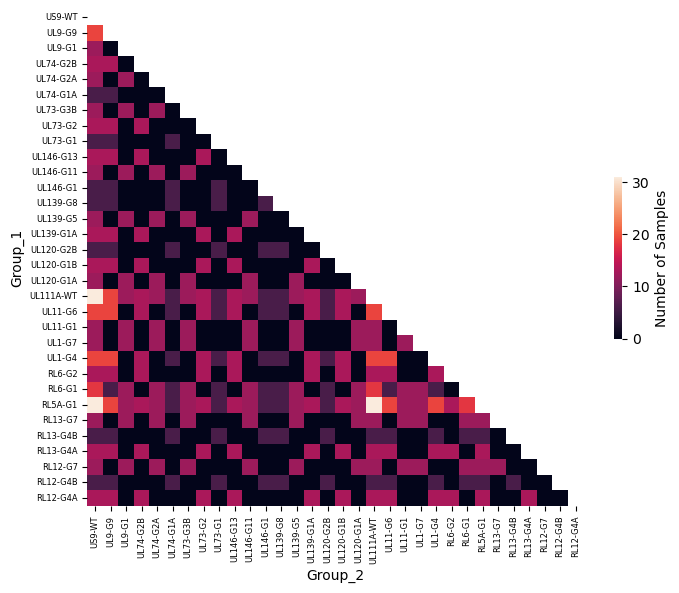

In [1]:
import pandas as pd
from glob import glob
import itertools
genotype_list = list()
files = glob('./genotyping/output/*.txt') 
for file in files:
    dat=pd.read_table(file, header = None)
    dat.iloc[:,2]= dat.iloc[:,2].str.replace(pat='>',repl='')
    genotypes= dat[(dat.iloc[:,0]>10) & (dat.iloc[:,2]!='control')].iloc[:,2]
    genotype_list.extend(list(itertools.permutations(genotypes, r=2)))

agregated=pd.Series(genotype_list).value_counts().to_frame(name='counts').reset_index()
dat=pd.DataFrame(agregated['index'].to_list(),columns=['Group_1','Group_2'])
dat['counts']=agregated['counts']
mat=dat.pivot(index='Group_1', columns='Group_2', values='counts')
mat.fillna(0, inplace=True)
#dat[dat["Group_1"]=="UL111A-WT"]
#dat[dat["Group_2"]=="UL111A-WT"]

import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(8, 7))
mask = np.tril(np.ones_like(mat) )
a=sb.heatmap(mat,annot=False, cbar_kws={'label': 'Number of Samples', 'shrink':0.3}, square=True, mask=mask)
a.tick_params(labelsize=6)
a.invert_xaxis()
a.invert_yaxis()
